In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 

## 尝试使用MPAS数据绘制分辨率变化
2021.08.04

new：
-   尝试修改色板的范围，让地理坐标在plt terrain的绿色部分
-   使用tricolorf从原始的经纬度一维序列绘制大致分辨率
-   修改投影方式，方便说明经纬度变化，使用大圆
-   尝试添加lalonbox标注选取的区域划分部分
-   添加分省的边界文件（包含南海的九段线）
-   添加河流shp文件
remains：

In [62]:
# fname_rcm = "/raid52/yycheng/MPAS/MESH/tpemip_grid/rcm_area/" + "china_rcm.grid.nc"
fname_rcm = "/raid52/yycheng/MPAS/MESH/tpemip_grid/vr_area/" + "ea.grid.nc"
# fname_rcm = "/raid52/yycheng/MPAS/MESH/x4.163842/" + "x4.163842.grid.nc"
ds_grid_rcm = xr.open_dataset(fname_rcm)

fname_topo = "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/" + "history.1998-04-01_00.00.00.nc"
zgrid      = xr.open_dataset(fname_topo)['zgrid'][:,0]

## 估算分辨率

分辨率估算方法1：直接从NCL计算resolution.ncl中摘抄；效果是非常平滑，但是最小分辨率存在问题，范围比较合适

In [63]:
areaCell = ds_grid_rcm['areaCell'] 
minSpacingKm = np.sqrt(np.min(areaCell)*2.0/np.sqrt(3.0))*6371.229

areaCell = ds_grid_rcm['areaCell'] 
maxSpacingKm = np.sqrt(np.max(areaCell)*2.0/np.sqrt(3.0))*6371.229

meanSpacingKm = np.sqrt(np.mean(areaCell)*2.0/np.sqrt(3.0))*6371.229

meshDensity = ds_grid_rcm['meshDensity']
fld_min = minSpacingKm / (meshDensity**0.25)
fld_max = maxSpacingKm / (meshDensity**0.25)
fld_mean = meanSpacingKm / (meshDensity**0.25)
# 直接使用25km作为最小的经纬度，再通过meshDensity预估出来
fld_spec = 24. / (meshDensity**0.25)

# r2d = 57.2957795             # radians to degrees
r2d = 180 / np.pi             # radians to degrees
lonCell   = ds_grid_rcm['lonCell'] * r2d
latCell   = ds_grid_rcm['latCell'] * r2d

mod_lon    = xr.open_dataset(fname_topo)['lonCell'] * r2d
mod_lat    = xr.open_dataset(fname_topo)['latCell'] * r2d

分辨率估算方法2：直接将上述方法应用在逐个mesh上，然后绘制逐个mesh的分辨率的等值线，在最小分辨率的位置不够平滑，范围会稍小

In [24]:
areaCell = ds_grid_rcm['areaCell'] 
# minSpacingKm = np.sqrt(np.min(areaCell)*2.0/np.sqrt(3.0))*6371.229
# maxSpacingKm = np.sqrt(np.max(areaCell)*2.0/np.sqrt(3.0))*6371.229
# meanSpacingKm = np.sqrt(np.mean(areaCell)*2.0/np.sqrt(3.0))*6371.229
meanSpacingKm = np.sqrt(areaCell*2.0/np.sqrt(3.0))*6371.229

meshDensity = ds_grid_rcm['meshDensity']
# fld_min = minSpacingKm / (meshDensity**0.25)
# fld_max = maxSpacingKm / (meshDensity**0.25)
# fld_mean = meanSpacingKm / (meshDensity**0.25)
fld_mean = meanSpacingKm / (meshDensity**0.25)

# r2d = 57.2957795             # radians to degrees
r2d = 180 / np.pi             # radians to degrees
lonCell   = ds_grid_rcm['lonCell'] * r2d
latCell   = ds_grid_rcm['latCell'] * r2d

mod_lon    = xr.open_dataset(fname_topo)['lonCell'] * r2d
mod_lat    = xr.open_dataset(fname_topo)['latCell'] * r2d

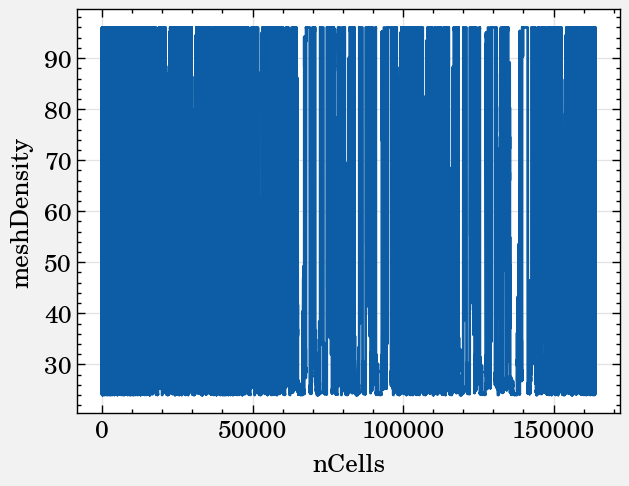

In [65]:
fld_spec.plot()

## 绘图

### 分辨率测试

/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/axes/geo.py:1044: ProPlotWarning: Cannot add gridline labels to cartopy LambertCylindrical projection.
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/axes/geo.py:1050: ProPlotWarning: Cannot add gridline labels to cartopy LambertCylindrical projection.


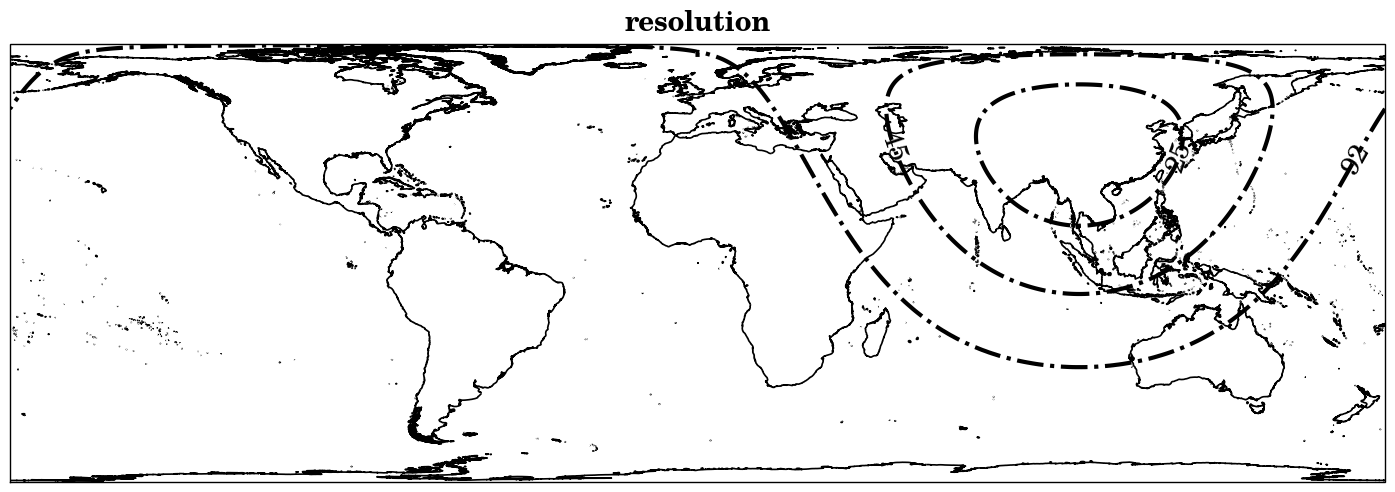

In [66]:
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

# ----- 分辨率reso，暂时用最小的 fld_min 替代，作为近似预估 -----
# reso = (fld_min + fld_max ) / 2.
reso = fld_spec

# ----- 绘图projection选取 -----
# fig, axs = pplt.subplots(ncols=1,nrows=1, proj=('cyl'))
# proj_sel = pplt.Proj('ortho', lon_0=100, lat_0=37.5) 
# proj_sel = pplt.Proj('stere', lon_0=100, lat_0=37.5) 
# proj_sel = ('cyl')
# 使用更高精度的 proj_sel 方便后续绘制box的时候不出现明显折线 (remark!!)
# proj_sel = ccrs.Orthographic(central_latitude=0., central_longitude=0.0)
# proj_sel._threshold /= 100.
proj_sel = ccrs.LambertCylindrical()

fig, axs = pplt.subplots(ncols=1,nrows=1, proj=proj_sel, figsize=(7,7))

#----- 等值线ticks -----
# reso_ticks = np.linspace(14, 100, 11)
reso_ticks = [25, 45, 92]
m_contour  = axs[0].tricontour(lonCell, latCell, reso, levels  = reso_ticks,color='k',linewidth = 1.5, linestyle = '-.')
axs[0].clabel(m_contour, inline=True, fontsize=10, colors = 'k', fmt='%2.0f',use_clabeltext=True, inline_spacing=0.2)

# ----- format setting -----

axs.format(
abc=False,
# lonlim=(55, 150), latlim=(-5, 70),
# lonlim=(60, 100), latlim=(10, 40),
#----- 地图底图设置 -----
reso = 'x-hi',
coast = True,
borders = False,
lakes = False,
land  = False,
ocean = False,
oceancolor = 'b',

#-----GEO axis-----
labels = True,
gridlabelsize = 5,

longrid  = False,
latgrid  = False,

latlines = 10,
lonlines = 10,
suptitle="resolution",
)



#----- save figure -----
fig.patch.set_facecolor('white')
# plt.savefig('./output_pic/domain_reso_add.png', dpi=600, facecolor= "white")

### 地形图叠加分辨率

In [6]:
zgrid_rmnan = zgrid.fillna(0)
zgrid_rmnan = np.where(zgrid_rmnan<0, 0 , zgrid_rmnan)

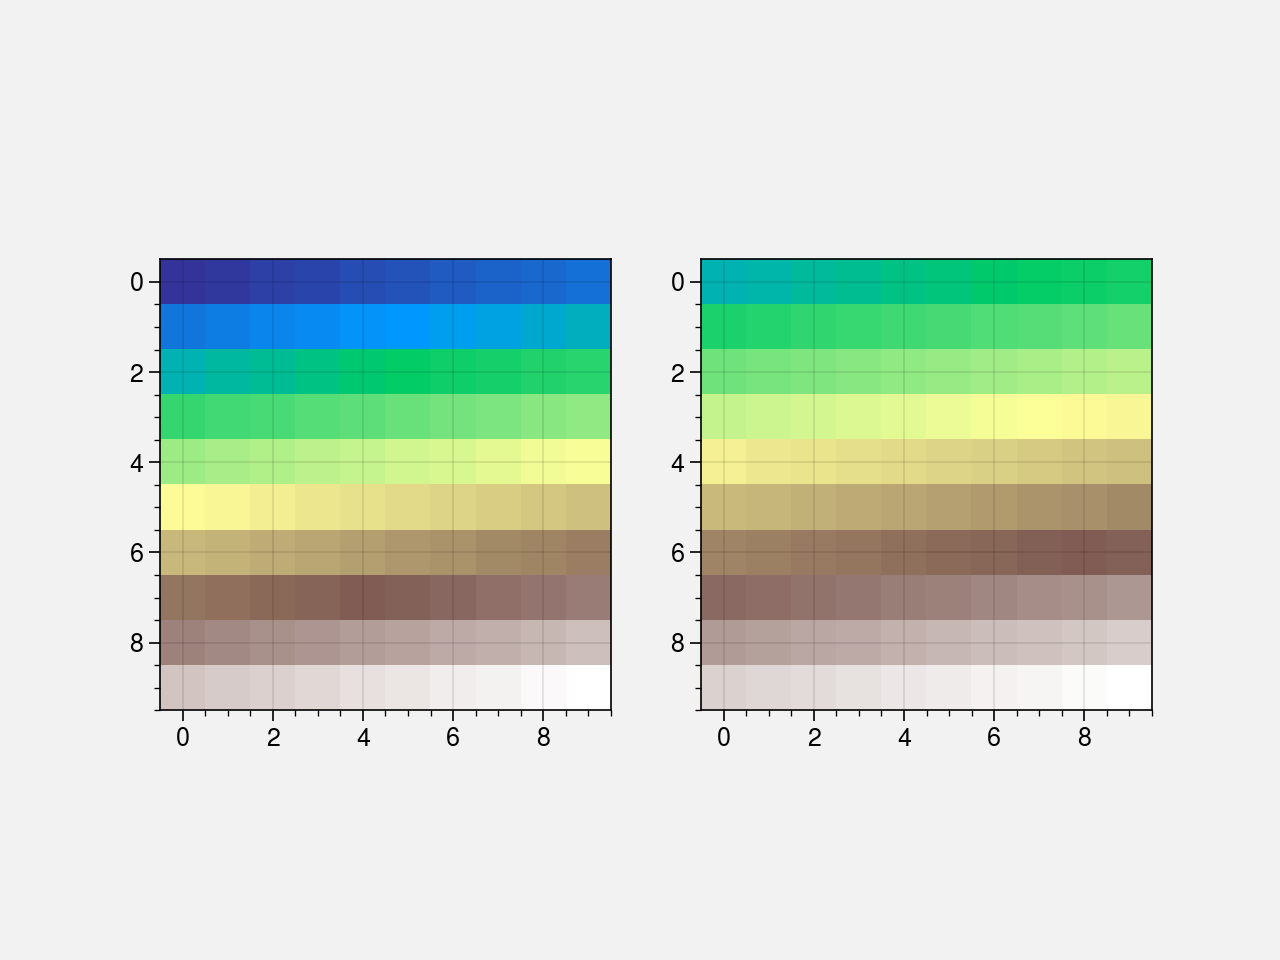

In [7]:
# 调整CMAP
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('terrain')
new_cmap = truncate_colormap(cmap, 0.2, 1.)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [8]:
# 从边界文件 border 进行省界绘制的部分
# Load the border data, CN-border-La.dat is download from
# https://gmt-china.org/data/CN-border-La.dat
import cartopy.crs as ccrs
cn_border_file = "/m2data2/yycheng/data_stage/CN-border/CN-border_line/CN-border-La.dat"
with open(cn_border_file) as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]

/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/axes/geo.py:1044: ProPlotWarning: Cannot add gridline labels to cartopy Orthographic projection.
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/axes/geo.py:1050: ProPlotWarning: Cannot add gridline labels to cartopy Orthographic projection.


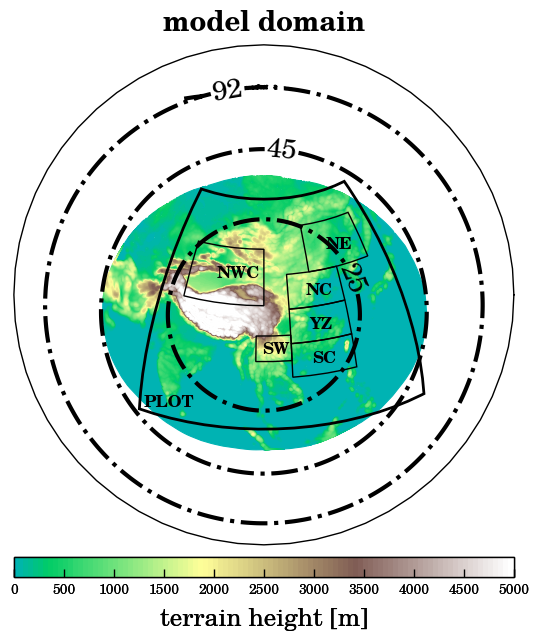

In [69]:
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

## shapefile数据下载的位置：
## http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
# world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"
world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/世界国家/" + "世界国家.shp"
river_border_shapefile =  "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/R1/" + "hyd1_4l.shp"
province_2015_changeproj_shapefile    = "/m2data2/yycheng/data_stage/CN-border/CN-sheng/" + "change_proj_CN-sheng-A.shp"
# 南海九段线
ninelines_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "nine_lines.shp"

# ----- 分辨率reso，暂时用最小的 fld_min 替代，作为近似预估 -----
# reso = (fld_min + fld_max ) / 2.
reso = fld_spec

# ----- 绘图projection选取 -----
# fig, axs = pplt.subplots(ncols=1,nrows=1, proj=('cyl'))
# proj_sel = pplt.Proj('ortho', lon_0=100, lat_0=37.5) 
# proj_sel = pplt.Proj('stere', lon_0=100, lat_0=37.5) 
# proj_sel = ('cyl')
# 使用更高精度的 proj_sel 方便后续绘制box的时候不出现明显折线 (remark!!)
proj_sel = ccrs.Orthographic(central_latitude=37.5, central_longitude=100.0)
proj_sel._threshold /= 100.

fig, axs = pplt.subplots(ncols=1,nrows=1, proj=proj_sel)
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

#----- 添加海洋以及行政区划 -----

# #---- 直接绘图，从边界文件添加
# # for ax_ind in axs:
# # for line in borders:
#     # axs.plot(line[0::100], line[1::100], lw = 0.5, color='gray',transform=ccrs.Geodetic())
#     # axs.plot(line[0::10], line[1::10], lw = 0.3, color='black',transform=ccrs.Geodetic())
# #---- 使用shp文件添加
# for ax in axs:
#     world = shpreader.Reader(world_border_shapefile).geometries()
#     river = shpreader.Reader(river_border_shapefile).geometries()
#     province_2015_change_proj = shpreader.Reader(province_2015_changeproj_shapefile , encoding = 'UTF8').geometries() # 地资所的shp，需要转换proj单位
#     ninelines  = shpreader.Reader(ninelines_shapefile, encoding = 'utf8').geometries()
 
#     ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.4, zorder=1)
#     ax.add_geometries(river, ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)
#     ax.add_geometries(province_2015_change_proj , ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.1,
#     linestyle = "-", zorder=1)
#     ax.add_geometries(ninelines, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.4, zorder=1)
#     # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='b'))
#     ax.add_feature(cfeature.OCEAN) # 添加海洋填色
#     # ax.set_global() # added following an answer to my question 并不知道有什么用，先加着
#     # ax.gridlines()

#----- 等值线ticks -----
# reso_ticks = np.linspace(14, 100, 11)
reso_ticks = [25, 45, 92]
# reso_ticks = [20,30]
# m_mean     = axs[0].tricontourf(lonCell, latCell, reso, levels = reso_ticks, cmap = cmap)
m_contour  = axs[0].tricontour(lonCell, latCell, reso, levels  = reso_ticks,color='k',linewidth = 1.5, linestyle = '-.')
# (latCell, lonCell, fld_min)
# 添加 color bar
# axs[0].colorbar(m_mean, loc='b', width=0.1,ticklabelsize=5,ticks=reso_ticks)
# 添加 contour 标注线
axs[0].clabel(m_contour, inline=True, fontsize=10, colors = 'k', fmt='%2.0f',use_clabeltext=True, inline_spacing=0.2)



#----- 添加地形等值线 -----
topo_ticks = np.linspace(0, 5000, 101)
topo = axs[0].tricontourf(mod_lon, mod_lat, zgrid_rmnan,\
levels=topo_ticks,cmap=new_cmap)
axs[0].colorbar(topo, loc='b', width=0.1,ticklabelsize=5,ticks=topo_ticks[::10], title='terrain height [m]')

#----- 添加 latlonbox -----
    # Build a rectangle in axes coords

lonlatbox =[
        [107, 98, 28, 22],
        [123, 107, 26, 18],
        [123, 107, 34, 26],
        [123, 107, 42, 34],
        [134, 114, 53, 42],  
        [100, 77, 48, 35],
        [140, 70, 60, 5]
            ]
boxname = ["SW", "SC", "YZ", "NC", "NE","NWC", "PLOT"]
for ind_box in range(0,7):
    # slon, slat, elon, elat = 70, 15, 140, 55
    elon, slon, elat, slat = lonlatbox[ind_box][0],lonlatbox[ind_box][1],lonlatbox[ind_box][2],lonlatbox[ind_box][3]

    if (boxname[ind_box]=='PLOT'):
        lw_sel = 1
    else:
        lw_sel = 0.5
    axs[0].add_patch(mpatches.Rectangle(xy=[slon, slat], width=(elon - slon), height=(elat - slat),
                                        fill=False,lw = lw_sel,
                                        transform=ccrs.PlateCarree()))
    # 填写区域名称 到区域的中心位置
    # 凭经验将区域名称移动了一下 -4 -4
    if(boxname[ind_box]!='PLOT'):
        text_lon = (slon + elon) / 2. - 3.
        text_lat = (slat + elat) / 2. - 1.
    else:
        text_lon = slon + 1.
        text_lat = slat + 1.
    axs[0].text(text_lon, text_lat, boxname[ind_box], fontsize = 6,fontweight='bold',
            transform=ccrs.PlateCarree())



# ----- format setting -----

axs.format(
abc=False,
# lonlim=(55, 150), latlim=(-5, 70),
# lonlim=(60, 100), latlim=(10, 40),
#----- 地图底图设置 -----
reso = 'x-hi',
coast = False,
borders = False,
lakes = False,
land  = False,
ocean = False,
oceancolor = 'b',
cartopyautoextent = True, 
# borderslinewidth=.5,
#-----GEO axis-----
labels = True,
gridlabelsize = 5,
# gridminor = False,
# ticklen = 10,
longrid  = False,
latgrid  = False,
# longridminor= False,
# latgridminor= False,
# lonminorlocator = 
# longrid  = True,
# latgrid  = True,
latlines = 10,
lonlines = 10,
# lonlocator = 20,
# latlocator = 10,
# lonlocator = np.arange(70,140,10),
# latlocator = np.arange(15,65,10),
# lonminorlocator = np.arange(70,140+2,5),
# latminorlocator = np.arange(15,55+2,5),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
suptitle="model domain",
)



#----- save figure -----
fig.patch.set_facecolor('white')
plt.savefig('./output_pic/domain_reso_add.png', dpi=600, facecolor= "white")